# Hercules data

In [ ]:
!ls -l data/2018

### Plot depth data

- flatted json into pandas dataframe (read_json_to_dataframe)
- deduplicate entries
- configure y-axis based on median and std deviation, and autorange that excludes outliers

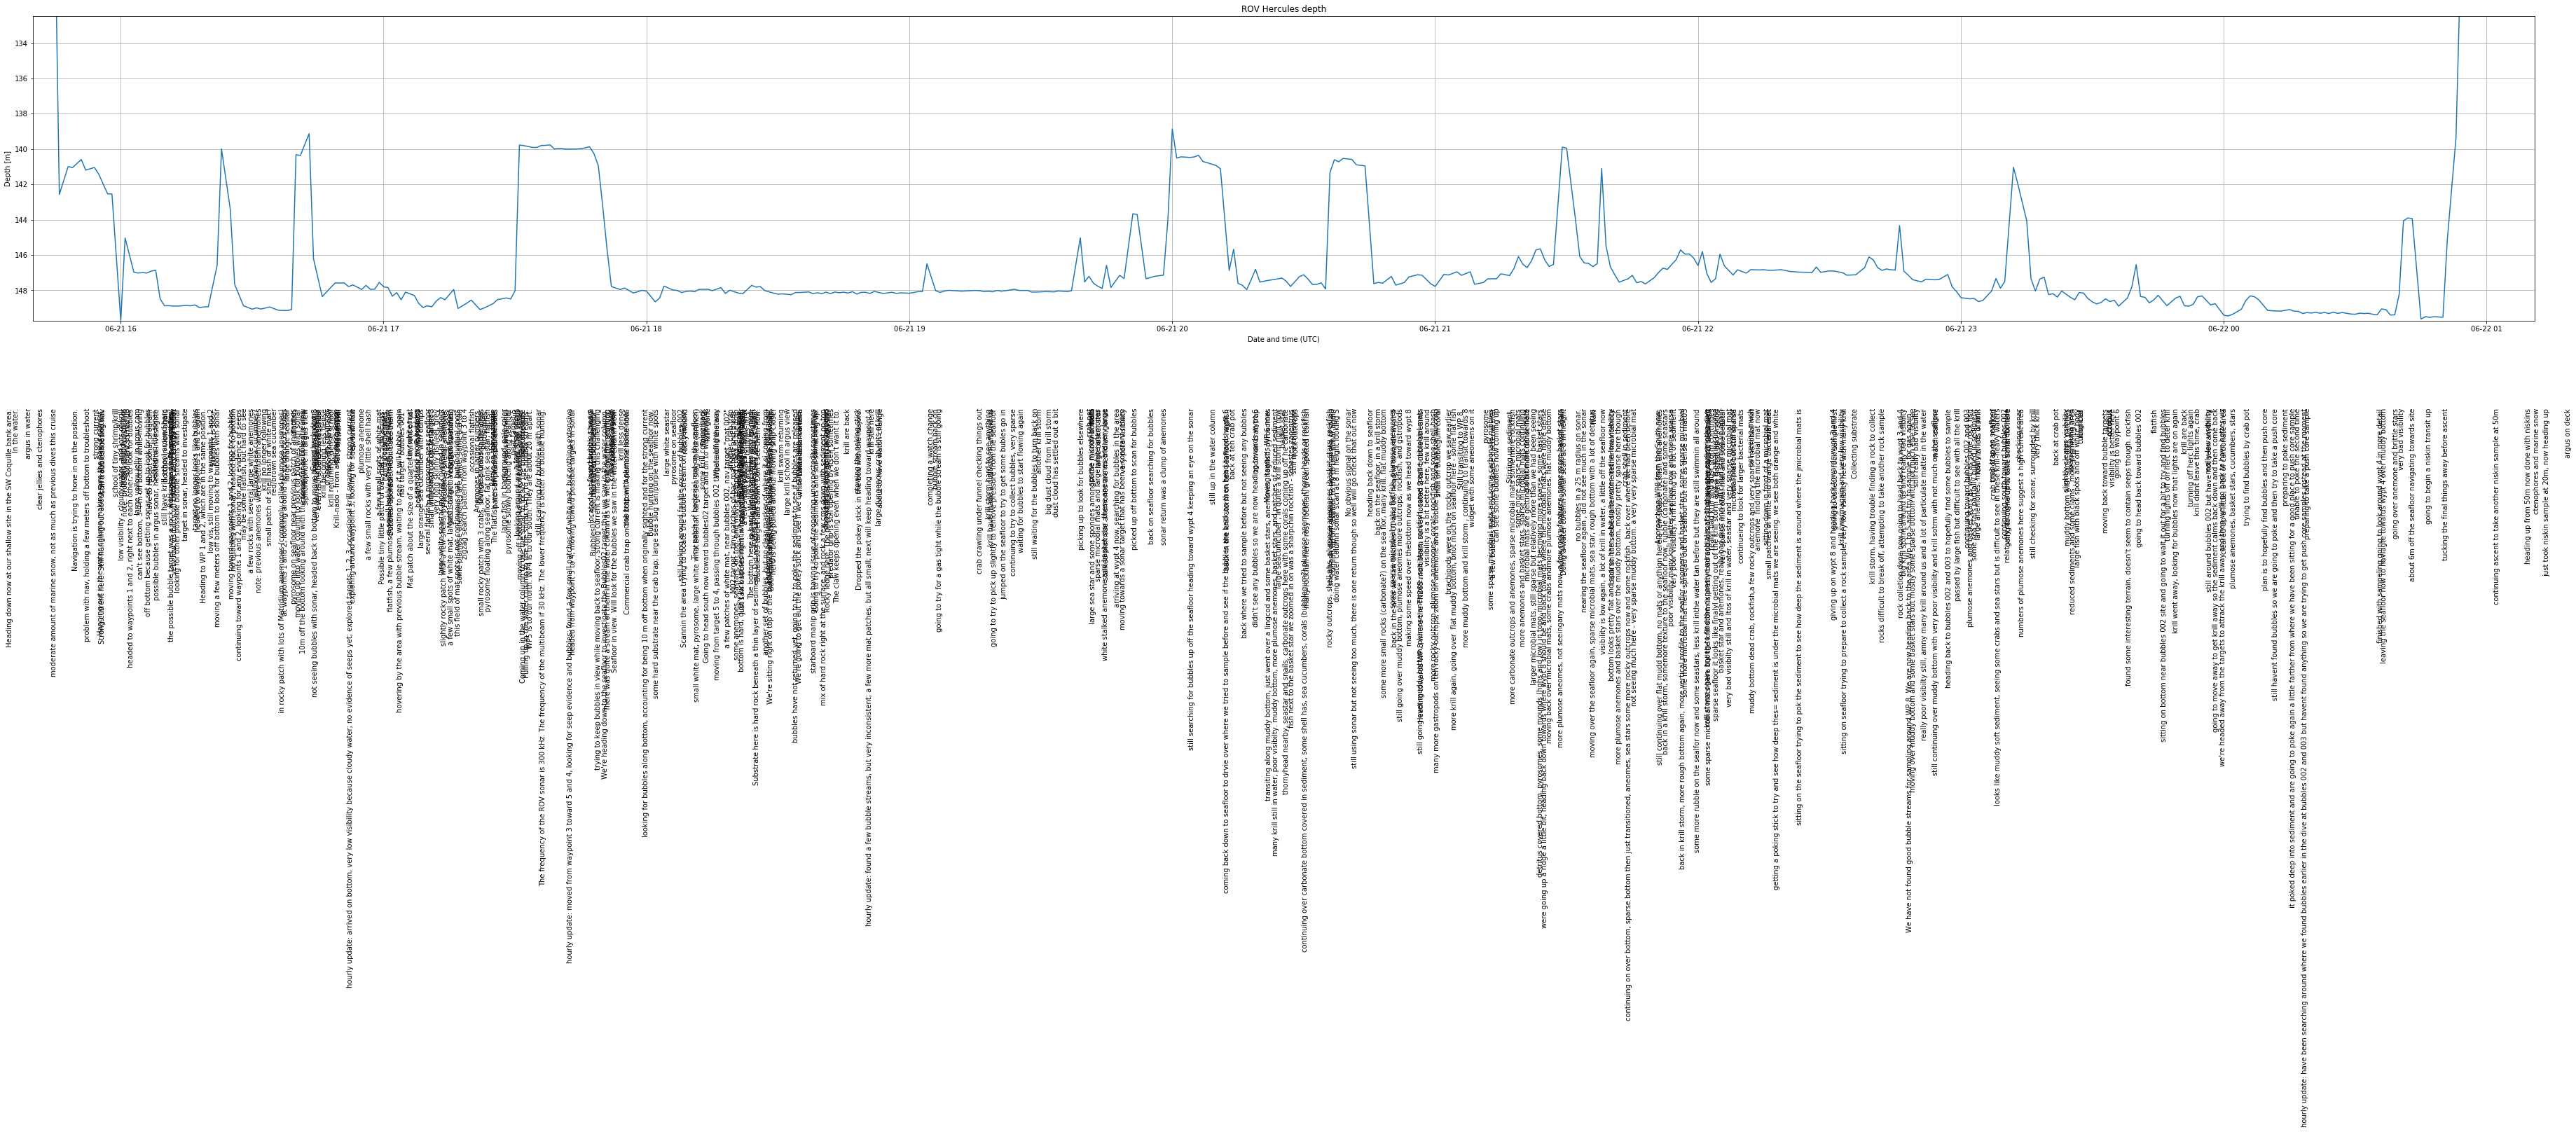

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd
from  dateutil.parser import parse as parseIso8601
def read_json_to_dataframe(filename):
    datas  = []
    for line in open(filename):
        data = json.loads(line)
        if data is not None:
            datas.append(data)

    return pd.io.json.json_normalize(datas)







df = read_json_to_dataframe('data/2018-06-21T18-23-35.json')
depth = df[["hercules.depth.value", "hercules.depth.dtmRecorded"]]
depth = depth.drop_duplicates(subset = "hercules.depth.dtmRecorded")


#conver to np datetimes
depth["hercules.depth.dtmRecorded"] = depth["hercules.depth.dtmRecorded"].apply(np.datetime64)

plt.figure(figsize=(64,8))




plt.plot(depth["hercules.depth.dtmRecorded"].values, depth["hercules.depth.value"].values)

m = depth['hercules.depth.value'].median() # max value of histogram
s = depth['hercules.depth.value'].std()    # standard deviation
plt.ylim(depth["hercules.depth.value"].max(), m-s/2)

# time when actually diving
xmin = depth[depth['hercules.depth.value'] > 20]["hercules.depth.dtmRecorded"].min()
xmax = depth[depth['hercules.depth.value'] > 20]["hercules.depth.dtmRecorded"].max()
plt.xlim(xmin,xmax)
plt.title("ROV Hercules depth")
plt.ylabel("Depth [m]")
plt.xlabel("Date and time (UTC)")
plt.grid()








# Nautilus log entries

from scipy.interpolate import interp1d


df = read_json_to_dataframe('data/2018-06-21T18-23-35.json')
log = df[["nautilus.eventlog.value", "nautilus.eventlog.dtmRecorded"]]

# Thee eventlogs are stored as arrays in the json, they need to be flattened
dtms = []
logs = []
for row in df["nautilus.eventlog.dtmRecorded"]:
    for value in row:
            dtms.append(value)

for row in df["nautilus.eventlog.value"]:
    for value in row:
            logs.append(value)

# Put the flattened eventlog data back into a DataFrame
eventlog = pd.DataFrame({"nautilus.eventlog.value": logs, "nautilus.eventlog.dtmRecorded": dtms})
eventlog = eventlog.drop_duplicates()
eventlog = eventlog.dropna()
eventlog = eventlog.sort_values(by=['nautilus.eventlog.dtmRecorded'])

# interpolate the depth of the event logs based on Herc depth data
#depth["hercules.depth.dtmRecorded"] = depth["hercules.depth.dtmRecorded"].apply(np.datetime64)
#depth_interp = interp1d(
#    x = [np.datetime64(item) for item in depth["hercules.depth.dtmRecorded"].values],
#    y = depth["hercules.depth.value"].values,
#    kind="linear"
#) 



i = 0
for row in eventlog.iterrows():

    plt.text(
        x = row[1]['nautilus.eventlog.dtmRecorded'],
        #y = depth['hercules.depth.value'].median(),
        y = 155,   ##############magic!!!!!!!
        s = row[1]['nautilus.eventlog.value'],
        rotation = "vertical"
    )

plt.savefig("./img/2018-06-21T18-23-35-herc-depth-with-eventlog.svg")
plt.show()

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

pd.reset_option('display.max_rows')

In [ ]:
import requests
url = 'http://nautiluslive.org/sites/default/files/nautilus-vehicle-data.json'
time.time * 1000
requests.get(url, data = dict(_ = time.time * 1000))

# Influx DB line protocol


In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import json
import calendar
import pandas as pd
from  dateutil.parser import parse as parseIso8601

from influxdb import InfluxDBClient

def read_json_to_dataframe(filename):
    datas  = []
    for line in open(filename):
        data = json.loads(line)
        if data is not None:
            datas.append(data)

    return pd.io.json.json_normalize(datas)


def iso8601ToInfluxTime(isostr):
    return calendar.timegm(parseIso8601(isostr).timetuple()) * 1000_000_000

df = read_json_to_dataframe('data/2018-06-21T18-23-35.json')
depth = df[["hercules.depth.value", "hercules.depth.dtmRecorded"]]
depth = depth.drop_duplicates(subset = "hercules.depth.dtmRecorded")
#depth["hercules.depth.dtmRecorded"] =  depth["hercules.depth.dtmRecorded"].apply(iso8601ToInfluxTime)